In [181]:
import numpy as np 
import pandas as pd 
import glob
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from ultralytics import YOLO
import cv2
import json
import torch
import torchvision
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# PREDICTION CLASSIFIEUR puis YOLOV8 SUR TEST

In [182]:


files = glob.glob("pathtoyourproject/shipdetection/data/original/test/*png")
model_path_yolo640 = "pathtoyourproject/shipdetection/runs/detect/TL_640_to640_LB083/weights/best.pt"
model_path_yolo1280 = "pathtoyourproject/shipdetection/runs/detect/yolov8m_1280_imgzs1280_last/best.pt"
model_path_classifieur = "pathtoyourproject/shipdetection/runs/classifieur/640_second/model_120.pt"




In [220]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)


def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    cv2_imshow(image) #if used in Colab
  else :
    plt.imshow(image) #if used in Python


def tuile_old(filename, size, recover=0.5):
    """
    decouper les grosses image en tuile. Il boucler dedans, reflechir a un taux de recouvrement
    verifier sur on conserve un label sur cette image, et il faut le recalculer

    les perfs dépendront beaucoup de cette fonction je pense
    """
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    Ylen, Xlen, channel = img.shape
    list_tile = []
    
    #TODO rajouter le cas où l'image fait 800*800
    
    for nb_X in tqdm(range(0, Xlen, int(size * recover))):
        for nb_Y in range(0, Ylen, int(size * recover)):
            if nb_X + size < Xlen and nb_Y + size < Ylen:
                
                list_tile.append((img[nb_Y:nb_Y + size, nb_X:nb_X + size, :],(nb_Y, nb_X, nb_Y + size, nb_X + size)))
    
    if not list_tile:
        print(f"size of the img {filename} is to small: {img.shape}")
        if Xlen>size:
            print(f"Xlen>size {Xlen>size} ")
            for nb_X in range(0, Xlen, int(size * recover)):
                ima_tile = img[:, nb_X:nb_X + size, :]
                list_tile.append((ima_tile,(0, nb_X, img.shape[0], nb_X+size)))

        elif Ylen>size:
            print(f"Ylen>size {Ylen>size} ")
            for nb_Y in range(0, Ylen, int(size * recover)):
                ima_tile = img[nb_Y:nb_Y + size,:, :]
                list_tile.append((ima_tile,(nb_Y, 0, nb_Y + size, img.shape[1])))
        else:
            list_tile.append((img,(0, 0, img.shape[0], img.shape[1])))
    
    return list_tile

def tuile(filename, size, recover=0.5):
    """
    decouper les grosses image en tuile. Il boucler dedans, reflechir a un taux de recouvrement
    verifier sur on conserve un label sur cette image, et il faut le recalculer

    les perfs dépendront beaucoup de cette fonction je pense
    """
    img = cv2.imread(filename)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    Ylen, Xlen, channel = img.shape
    list_tile = []



    over = False
    toosmall = False
    if size <= Xlen and size <= Ylen:
        for nb_Y in range(0, Ylen, int(size * recover)):

            for nb_X in tqdm(range(0, Xlen, int(size * recover))):

                if nb_X + size < Xlen and nb_Y + size < Ylen:

                    list_tile.append(
                        (img[nb_Y:nb_Y + size, nb_X:nb_X + size, :], (nb_Y, nb_X, nb_Y + size, nb_X + size)))
                elif nb_X + size > Xlen and nb_Y + size > Ylen:
                    list_tile.append(
                        (img[Ylen - size:Ylen, Xlen - size:Xlen, :], (Ylen - size, Xlen - size, Ylen, Xlen)))
                    over = True
                    break
                elif nb_X + size > Xlen:
                    list_tile.append(
                        (img[nb_Y:nb_Y + size, Xlen - size:Xlen, :], (nb_Y, Xlen - size, nb_Y + size, Xlen)))
                    break
                elif nb_Y + size > Ylen:
                    list_tile.append(
                        (img[Ylen - size:Ylen, nb_X:nb_X + size, :], (Ylen - size, nb_X, Ylen, nb_X + size)))

            if over:
                break

    elif size > Xlen and size > Ylen:
        print(f"size of the img {filename} is to small: {img.shape}")
        if Xlen > size:
            print(f"Xlen>size {Xlen > size} ")
            for nb_X in range(0, Xlen, int(size * recover)):
                ima_tile = img[:, nb_X:nb_X + size, :]
                list_tile.append((ima_tile, (0, nb_X, img.shape[0], nb_X + size)))
                

        elif Ylen > size:
            print(f"Ylen>size {Ylen > size} ")
            for nb_Y in range(0, Ylen, int(size * recover)):
                ima_tile = img[nb_Y:nb_Y + size, :, :]
                list_tile.append((ima_tile, (nb_Y, 0, nb_Y + size, img.shape[1])))
                
        else:
            list_tile.append((img, (0, 0, img.shape[0], img.shape[1])))
            toosmall=True

    elif size > Xlen:
        for nb_Y in range(0, Ylen, int(size * recover)):
            if nb_Y + size > Ylen:
                list_tile.append((img[Ylen - size:Ylen, :, :], (Ylen - size, 0, Ylen, Xlen)))
                break
            list_tile.append((img[nb_Y:nb_Y + size, :, :], (nb_Y, 0, Ylen, Xlen)))
    elif size > Ylen:
        for nb_X in tqdm(range(0, Xlen, int(size * recover))):
            if nb_X + size > Xlen:
                list_tile.append((img[:, Xlen - size:Xlen, :], (0, Xlen - size, Ylen, Xlen)))
                break
            list_tile.append((img[:, nb_X:nb_X + size, :], (0, nb_X, Ylen, nb_X + size)))

    return list_tile,toosmall

# LOAD MODEL

In [184]:
model_yolo640 = YOLO(model_path_yolo640)
# model_yolo1280 = YOLO(model_path_yolo1280)

In [186]:
input_size = 1024

data_transforms = {
    'train': A.Compose([
        A.Resize(input_size, input_size),
        A.CenterCrop(input_size, input_size),
        A.HorizontalFlip(),
        A.RandomFog(),
        A.RandomRotate90(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
    'val': A.Compose([
        A.Resize(input_size, input_size),
        A.CenterCrop(input_size, input_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
    'faster': A.Compose([
        A.Resize(input_size, input_size),
        A.CenterCrop(input_size, input_size),

        ToTensorV2()
    ]),
}

In [247]:

filename = files[7]
print(filename)
list_tile1280,toosmall = tuile(filename, 1024, recover=0.2)
list_tile640,_ = tuile(filename, 640, recover=0.2)
print(f"il y a {len(list_tile1280)} tiles")


pathtoyourproject/shipdetection/data/original/test/104.png
(1024, 1024, 3)


 17%|██████████████████████████████                                                                                                                                                      | 1/6 [00:00<00:00, 19065.02it/s]


(1024, 1024, 3)


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 4/8 [00:00<00:00, 108240.10it/s]

il y a 3 tiles


In [248]:
# for tile,orig_size in list_tile1280:
#     plt.imshow(tile)
#     plt.show()

# USE CLASSIFIEUR FOR MAKING PREDICTION FOR YOLOV8

In [249]:
import torch
import numpy as np

def rbox2poly(obboxes):
    """
    Trans rbox format to poly format.
    Args:
        rboxes (array/tensor): (num_gts, [cx cy l s θ]) θ∈[-pi/2, pi/2)
    Returns:
        polys (array/tensor): (num_gts, [x1 y1 x2 y2 x3 y3 x4 y4]) 
    """
    if isinstance(obboxes, torch.Tensor):
        center, w, h, theta = obboxes[:, :2], obboxes[:, 2:3], obboxes[:, 3:4], obboxes[:, 4:5]
        Cos, Sin = torch.cos(theta), torch.sin(theta)

        vector1 = torch.cat(
            (w/2 * Cos, -w/2 * Sin), dim=-1)
        vector2 = torch.cat(
            (-h/2 * Sin, -h/2 * Cos), dim=-1)
        point1 = center + vector1 + vector2
        point2 = center + vector1 - vector2
        point3 = center - vector1 - vector2
        point4 = center - vector1 + vector2
        order = obboxes.shape[:-1]
        return torch.cat(
            (point1, point2, point3, point4), dim=-1).reshape(*order, 8)
    else:
        center, w, h, theta = np.split(obboxes, (2, 3, 4), axis=-1)
        Cos, Sin = np.cos(theta), np.sin(theta)

        vector1 = np.concatenate(
            [w/2 * Cos, -w/2 * Sin], axis=-1)
        vector2 = np.concatenate(
            [-h/2 * Sin, -h/2 * Cos], axis=-1)

        point1 = center + vector1 + vector2
        point2 = center + vector1 - vector2
        point3 = center - vector1 - vector2
        point4 = center - vector1 + vector2
        order = obboxes.shape[:-1]
        return np.concatenate(
            [point1, point2, point3, point4], axis=-1).reshape(*order, 8)

def scale_polys(img1_shape, polys, img0_shape, ratio_pad=None):
    # ratio_pad: [(h_raw, w_raw), (hw_ratios, wh_paddings)]
    # Rescale coords (xyxyxyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = resized / raw
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0] # h_ratios
        pad = ratio_pad[1] # wh_paddings

    polys[:, [0, 2, 4, 6]] -= pad[0]  # x padding
    polys[:, [1, 3, 5, 7]] -= pad[1]  # y padding
    polys[:, :8] /= gain # Rescale poly shape to img0_shape
    #clip_polys(polys, img0_shape)
    return polys
    
def _create(name, pretrained=True, channels=3, classes=80, autoshape=True, verbose=True, device=None):
    """Creates a specified YOLOv5 model
    Arguments:
        name (str): name of model, i.e. 'yolov5s'
        pretrained (bool): load pretrained weights into the model
        channels (int): number of input channels
        classes (int): number of model classes
        autoshape (bool): apply YOLOv5 .autoshape() wrapper to model
        verbose (bool): print all information to screen
        device (str, torch.device, None): device to use for model parameters
    Returns:
        YOLOv5 pytorch model
    """
    from pathlib import Path

    from models.common import AutoShape, DetectMultiBackend
    from models.yolo import Model
    from utils.downloads import attempt_download
    from utils.general import check_requirements, intersect_dicts, set_logging
    from utils.torch_utils import select_device

    check_requirements(exclude=('tensorboard', 'thop', 'opencv-python'))
    set_logging(verbose=verbose)

    name = Path(name)
    path = name.with_suffix('.pt') if name.suffix == '' else name  # checkpoint path
    try:
        device = select_device(('0' if torch.cuda.is_available() else 'cpu') if device is None else device)

        if pretrained and channels == 3 and classes == 80:
            model = DetectMultiBackend(path, device=device)  # download/load FP32 model
            # model = models.experimental.attempt_load(path, map_location=device)  # download/load FP32 model
        else:
            cfg = list((Path(__file__).parent / 'models').rglob(f'{path.stem}.yaml'))[0]  # model.yaml path
            model = Model(cfg, channels, classes)  # create model
            if pretrained:
                ckpt = torch.load(attempt_download(path), map_location=device)  # load
                csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
                csd = intersect_dicts(csd, model.state_dict(), exclude=['anchors'])  # intersect
                model.load_state_dict(csd, strict=False)  # load
                if len(ckpt['model'].names) == classes:
                    model.names = ckpt['model'].names  # set class names attribute
        if autoshape:
            model = AutoShape(model)  # for file/URI/PIL/cv2/np inputs and NMS
        return model.to(device)

    except Exception as e:
        help_url = 'https://github.com/ultralytics/yolov5/issues/36'
        s = 'Cache may be out of date, try `force_reload=True`. See %s for help.' % help_url
        raise Exception(s) from e
        
def custom(path='path/to/model.pt', autoshape=True, verbose=True, device=None):
    # YOLOv5 custom or local model
    return _create(path, autoshape=autoshape, verbose=verbose, device=device)


In [250]:
from models.common import DetectMultiBackend

model_yolov5 = DetectMultiBackend("pathtoyourproject/shipdetection/models/dotayolo/yolov5m_finetune/weights/best.pt",device=torch.device('cuda:0'))

boxpred = []
clspred = []
names = ['plane', 'baseball-diamond', 'bridge', 'ground-track-field', 'small-vehicle', 'large-vehicle', 'ship',
                 'tennis-court',
                 'basketball-court', 'storage-tank', 'soccer-ball-field', 'roundabout', 'harbor', 'swimming-pool',
                 'helicopter', 'container-crane']
conf_thres = 0.25
pi = 3.141592
size_o = []
print(toosmall)
if not toosmall:
    for tile1280, orig_size1280 in tqdm(list_tile1280):
        fasterimg = data_transforms['faster'](image=tile1280)['image']
        prediction = model_yolov5(fasterimg.unsqueeze(0).type(torch.float32).cuda() / 255., augment=True)
        prediction.detach().cpu()
        nc = prediction.shape[2] - 5 - 180  # number of classes
        xc = prediction[..., 4] > 0.25  # candidates
        class_index = nc + 5
        x = prediction[0][xc[0]]
        # Compute conf
        x[:, 5:class_index] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        _, theta_pred = torch.max(x[:, class_index:], 1, keepdim=True)  # [n_conf_thres, 1] θ ∈ int[0, 179]
        theta_pred = (theta_pred - 90) / 180 * pi  # [n_conf_thres, 1] θ ∈ [-pi/2, pi/2)

        # multilabeling
        conf, j = x[:, 5:class_index].max(1, keepdim=True)
        x = torch.cat((x[:, :4], theta_pred, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        x = x[(x[:, 6:7] == torch.tensor(6, device=x.device)).any(1)]
        pred_poly = rbox2poly(x[:, :5])
        det = torch.cat((pred_poly, x[:, -2:]), dim=1)
        for *poly, conf, cls in reversed(det):
            c = int(cls)  # integer class
            label = names[c]
            xmax, xmin, ymax, ymin = max(poly[0::2]), min(poly[0::2]), max(poly[1::2]), min(poly[1::2])
            boxesc = torch.tensor([xmin, ymin, xmax, ymax]) + np.array(
                [orig_size1280[1], orig_size1280[0], orig_size1280[1], orig_size1280[0]], dtype=np.float32)
            clsc = torch.tensor(conf)
            boxpred.append(boxesc.unsqueeze(0).cpu())
            clspred.append(clsc.unsqueeze(0).cpu())
        del prediction, x, xc, theta_pred, det


else:
    for tile640,orig_size640 in list_tile640:

        yolop = model_yolo640.predict(tile640,augment=True)[0]
        box = yolop.boxes.boxes.detach().cpu()
        boxes=box[:,:4]+np.array([orig_size640[1],orig_size640[0],orig_size640[1],orig_size640[0]],dtype=np.float32)
        cls = box[:,4]
        boxpred.append(boxes)
        clspred.append(cls)
        del yolop


    

boxpred = torch.concat(boxpred,0)
clspred = torch.concat(clspred,0)
    

Fusing layers... 
Model Summary: 290 layers, 21640929 parameters, 0 gradients, 50.4 GFLOPs


False


  0%|                                                                                                                                                                                               | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_170673/2758072477.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clsc = torch.tensor(conf)
 33%|█████████████████████████████████████████████████████████████                                                                                                                          | 1/3 [00:00<00:00,  4.93it/s]/tmp/ipykernel_170673/2758072477.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clsc = torch.tensor(conf)
 67%|███████████████████████████████

In [251]:
indice_keep = torchvision.ops.nms(boxes=boxpred,scores=clspred,iou_threshold=0.5)
print(f"keep : {len(indice_keep)} sur {boxpred.shape[0]}")

boxkeep = boxpred[indice_keep]
clskeep = clspred[indice_keep]


keep : 18 sur 471


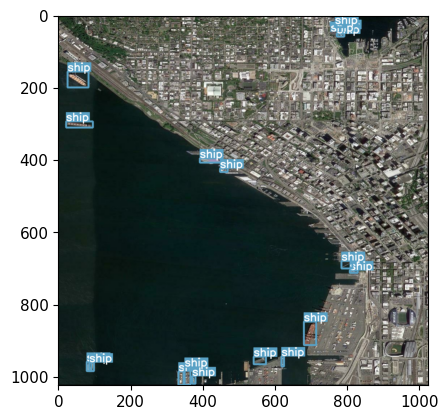

In [252]:
%matplotlib inline
from matplotlib import pyplot as plt
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_bboxes(img, torch.concat((boxkeep,clskeep.view(-1,1),torch.zeros_like(clskeep).view(-1,1)),-1), labels={0: u'__background__', 1: u'ship'}, colors=[], score=False, conf=None)
plt.show()

In [253]:
# import torch
# import numpy as np

# def rbox2poly(obboxes):
#     """
#     Trans rbox format to poly format.
#     Args:
#         rboxes (array/tensor): (num_gts, [cx cy l s θ]) θ∈[-pi/2, pi/2)
#     Returns:
#         polys (array/tensor): (num_gts, [x1 y1 x2 y2 x3 y3 x4 y4]) 
#     """
#     if isinstance(obboxes, torch.Tensor):
#         center, w, h, theta = obboxes[:, :2], obboxes[:, 2:3], obboxes[:, 3:4], obboxes[:, 4:5]
#         Cos, Sin = torch.cos(theta), torch.sin(theta)

#         vector1 = torch.cat(
#             (w/2 * Cos, -w/2 * Sin), dim=-1)
#         vector2 = torch.cat(
#             (-h/2 * Sin, -h/2 * Cos), dim=-1)
#         point1 = center + vector1 + vector2
#         point2 = center + vector1 - vector2
#         point3 = center - vector1 - vector2
#         point4 = center - vector1 + vector2
#         order = obboxes.shape[:-1]
#         return torch.cat(
#             (point1, point2, point3, point4), dim=-1).reshape(*order, 8)
#     else:
#         center, w, h, theta = np.split(obboxes, (2, 3, 4), axis=-1)
#         Cos, Sin = np.cos(theta), np.sin(theta)

#         vector1 = np.concatenate(
#             [w/2 * Cos, -w/2 * Sin], axis=-1)
#         vector2 = np.concatenate(
#             [-h/2 * Sin, -h/2 * Cos], axis=-1)

#         point1 = center + vector1 + vector2
#         point2 = center + vector1 - vector2
#         point3 = center - vector1 - vector2
#         point4 = center - vector1 + vector2
#         order = obboxes.shape[:-1]
#         return np.concatenate(
#             [point1, point2, point3, point4], axis=-1).reshape(*order, 8)

# def scale_polys(img1_shape, polys, img0_shape, ratio_pad=None):
#     # ratio_pad: [(h_raw, w_raw), (hw_ratios, wh_paddings)]
#     # Rescale coords (xyxyxyxy) from img1_shape to img0_shape
#     if ratio_pad is None:  # calculate from img0_shape
#         gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = resized / raw
#         pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
#     else:
#         gain = ratio_pad[0][0] # h_ratios
#         pad = ratio_pad[1] # wh_paddings

#     polys[:, [0, 2, 4, 6]] -= pad[0]  # x padding
#     polys[:, [1, 3, 5, 7]] -= pad[1]  # y padding
#     polys[:, :8] /= gain # Rescale poly shape to img0_shape
#     #clip_polys(polys, img0_shape)
#     return polys
    
# def _create(name, pretrained=True, channels=3, classes=80, autoshape=True, verbose=True, device=None):
#     """Creates a specified YOLOv5 model
#     Arguments:
#         name (str): name of model, i.e. 'yolov5s'
#         pretrained (bool): load pretrained weights into the model
#         channels (int): number of input channels
#         classes (int): number of model classes
#         autoshape (bool): apply YOLOv5 .autoshape() wrapper to model
#         verbose (bool): print all information to screen
#         device (str, torch.device, None): device to use for model parameters
#     Returns:
#         YOLOv5 pytorch model
#     """
#     from pathlib import Path

#     from models.common import AutoShape, DetectMultiBackend
#     from models.yolo import Model
#     from utils.downloads import attempt_download
#     from utils.general import check_requirements, intersect_dicts, set_logging
#     from utils.torch_utils import select_device

#     check_requirements(exclude=('tensorboard', 'thop', 'opencv-python'))
#     set_logging(verbose=verbose)

#     name = Path(name)
#     path = name.with_suffix('.pt') if name.suffix == '' else name  # checkpoint path
#     try:
#         device = select_device(('0' if torch.cuda.is_available() else 'cpu') if device is None else device)

#         if pretrained and channels == 3 and classes == 80:
#             model = DetectMultiBackend(path, device=device)  # download/load FP32 model
#             # model = models.experimental.attempt_load(path, map_location=device)  # download/load FP32 model
#         else:
#             cfg = list((Path(__file__).parent / 'models').rglob(f'{path.stem}.yaml'))[0]  # model.yaml path
#             model = Model(cfg, channels, classes)  # create model
#             if pretrained:
#                 ckpt = torch.load(attempt_download(path), map_location=device)  # load
#                 csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
#                 csd = intersect_dicts(csd, model.state_dict(), exclude=['anchors'])  # intersect
#                 model.load_state_dict(csd, strict=False)  # load
#                 if len(ckpt['model'].names) == classes:
#                     model.names = ckpt['model'].names  # set class names attribute
#         if autoshape:
#             model = AutoShape(model)  # for file/URI/PIL/cv2/np inputs and NMS
#         return model.to(device)

#     except Exception as e:
#         help_url = 'https://github.com/ultralytics/yolov5/issues/36'
#         s = 'Cache may be out of date, try `force_reload=True`. See %s for help.' % help_url
#         raise Exception(s) from e
        
# def custom(path='path/to/model.pt', autoshape=True, verbose=True, device=None):
#     # YOLOv5 custom or local model
#     return _create(path, autoshape=autoshape, verbose=verbose, device=device)


In [254]:
# # model.load_state_dict(torch.load("pathtoyourproject/shipdetection/models/dotayolo/yolov5m_finetune/weights/best.pt"))
# from models.common import DetectMultiBackend

# model = DetectMultiBackend("pathtoyourproject/shipdetection/models/dotayolo/yolov5m_finetune/weights/best.pt",device=torch.device('cpu'))


In [255]:
# input_size=1024

# data_transforms = {
#         'train': A.Compose([
#             A.Resize(input_size,input_size),
#             A.CenterCrop(input_size,input_size),
#             A.HorizontalFlip(),
#             A.RandomFog(),
#             A.RandomRotate90(),
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2()
#         ]),
#         'val': A.Compose([
#             A.Resize(input_size,input_size),
#             A.CenterCrop(input_size,input_size),
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2()
#         ]),
#     'faster': A.Compose([
#             A.Resize(input_size,input_size),
#             A.CenterCrop(input_size,input_size),
        
#             ToTensorV2()
#         ]),
#     }

In [256]:
# from utils.plots import Annotator, colors, save_one_box
# boxpred = []
# clspred = []
# size_o = []
# names = ['plane', 'baseball-diamond', 'bridge', 'ground-track-field', 'small-vehicle', 'large-vehicle', 'ship', 'tennis-court',
#             'basketball-court', 'storage-tank',  'soccer-ball-field', 'roundabout', 'harbor', 'swimming-pool', 'helicopter', 'container-crane']
# conf_thres=0.25
# pi = 3.141592

# for tile1280,orig_size1280 in tqdm(list_tile1280):
#     fasterimg = data_transforms['faster'](image=tile1280)['image']
#     prediction = model(fasterimg.unsqueeze(0).type(torch.float32)/255.,augment=True)
#     nc = prediction.shape[2] - 5 - 180  # number of classes
#     xc = prediction[..., 4] > 0.25  # candidates
#     class_index = nc + 5
#     x = prediction[0][xc[0]]
#     # Compute conf
#     x[:, 5:class_index] *= x[:, 4:5]  # conf = obj_conf * cls_conf

#     _, theta_pred = torch.max(x[:, class_index:], 1,  keepdim=True) # [n_conf_thres, 1] θ ∈ int[0, 179]
#     theta_pred = (theta_pred - 90) / 180 * pi # [n_conf_thres, 1] θ ∈ [-pi/2, pi/2)

#     #multilabeling
#     conf, j = x[:, 5:class_index].max(1, keepdim=True)
#     x = torch.cat((x[:, :4], theta_pred, conf, j.float()), 1)[conf.view(-1) > conf_thres]

#     x = x[(x[:, 6:7] == torch.tensor(6, device=x.device)).any(1)]
#     pred_poly = rbox2poly(x[:, :5])
#     det = torch.cat((pred_poly, x[:, -2:]), dim=1)
#     for *poly, conf, cls in reversed(det):
#         c = int(cls)  # integer class
#         label = names[c]
#         xmax, xmin, ymax, ymin = max(poly[0::2]), min(poly[0::2]), max(poly[1::2]), min(poly[1::2])
#         boxesc = torch.tensor([xmin,ymin,xmax,ymax])+np.array([orig_size1280[1],orig_size1280[0],orig_size1280[1],orig_size1280[0]],dtype=np.float32)
#         clsc = conf
#         boxpred.append(boxesc)
#         clspred.append(clsc)
#     del prediction,x,xc,theta_pred,det
        
    


In [257]:
# boxpred = torch.stack(boxpred,0)
# clspred = torch.stack(clspred,0)

# indice_keep = torchvision.ops.nms(boxes=boxpred,scores=clspred,iou_threshold=0.5)
# print(f"keep : {len(indice_keep)} sur {boxpred.shape[0]}")

# boxkeep = boxpred[indice_keep]
# clskeep = clspred[indice_keep]


# img = cv2.imread(filename)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plot_bboxes(img, torch.concat((boxkeep,clskeep.view(-1,1),torch.zeros_like(clskeep).view(-1,1)),-1), labels={0: u'__background__', 1: u'ship'}, colors=[], score=False, conf=None)

In [258]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# plot_bboxes(img, torch.concat((boxkeep,clskeep.view(-1,1),torch.zeros_like(clskeep).view(-1,1)),-1), labels={0: u'__background__', 1: u'ship'}, colors=[], score=False, conf=None)
# plt.show()

In [259]:
# fasterimg = data_transforms['faster'](image=list_tile1280[2][0])['image']
# print(fasterimg.shape)
# prediction = model(fasterimg.unsqueeze(0).type(torch.float32)/255.,augment=True)
# print(prediction.shape)

In [260]:
# nc = prediction.shape[2] - 5 - 180  # number of classes
# xc = prediction[..., 4] > 0.25  # candidates
# class_index = nc + 5
# print(nc,class_index)

In [261]:
# print(xc.shape)

In [262]:
# x = prediction[0][xc[0]]
# print(x.shape)
# #prediction (tensor): (b, n_all_anchors, [cx cy l s obj num_cls theta_cls])

In [263]:
# names = ['plane', 'baseball-diamond', 'bridge', 'ground-track-field', 'small-vehicle', 'large-vehicle', 'ship', 'tennis-court',
#             'basketball-court', 'storage-tank',  'soccer-ball-field', 'roundabout', 'harbor', 'swimming-pool', 'helicopter', 'container-crane']

# conf_thres=0.25
# pi = 3.141592
# # Compute conf
# x[:, 5:class_index] *= x[:, 4:5]  # conf = obj_conf * cls_conf

# _, theta_pred = torch.max(x[:, class_index:], 1,  keepdim=True) # [n_conf_thres, 1] θ ∈ int[0, 179]
# theta_pred = (theta_pred - 90) / 180 * pi # [n_conf_thres, 1] θ ∈ [-pi/2, pi/2)

# #multilabeling
# conf, j = x[:, 5:class_index].max(1, keepdim=True)
# x = torch.cat((x[:, :4], theta_pred, conf, j.float()), 1)[conf.view(-1) > conf_thres]

# x = x[(x[:, 6:7] == torch.tensor(6, device=x.device)).any(1)]

In [264]:
# x.shape

In [265]:
# pred_poly = rbox2poly(x[:, :5])

In [266]:
# det = torch.cat((pred_poly, x[:, -2:]), dim=1)

In [267]:
# s=" "
# for c in det[:, -1].unique():
#     n = (det[:, -1] == c).sum()  # detections per class
#     s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
# print(s)

In [268]:
# from utils.plots import Annotator, colors, save_one_box

In [269]:
# annotator = Annotator(img, line_width=3, example="shipp")

In [270]:
# boxpred = []
# clspred = []
# for *poly, conf, cls in reversed(det):
#     c = int(cls)  # integer class
#     label = names[c]
#     xmax, xmin, ymax, ymin = max(poly[0::2]), min(poly[0::2]), max(poly[1::2]), min(poly[1::2])
#     boxpred.append([xmin,ymin,xmax,ymax])
#     clspred.append(conf)
#     annotator.poly_label(poly, label)#, color='92CC17')

# print(len(boxpred))
# print(len(boxpred[0]))
# boxpred = torch.tensor(boxpred)+torch.tensor([list_tile1280[2][1][1],list_tile1280[2][1][0],list_tile1280[2][1][1],list_tile1280[2][1][0]])
# clspred = torch.tensor(clspred)
# indice_keep = torchvision.ops.nms(boxes=boxpred,scores=clspred,iou_threshold=0.5)
# print(f"keep : {len(indice_keep)} sur {boxpred.shape[0]}")

# boxkeep = boxpred[indice_keep]
# clskeep = clspred[indice_keep]


# img = cv2.imread(filename)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plot_bboxes(img, torch.concat((boxkeep,clskeep.view(-1,1),torch.zeros_like(clskeep).view(-1,1)),-1), labels={0: u'__background__', 1: u'ship'}, colors=[], score=False, conf=None)

In [271]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# im0 = annotator.result()
# plt.imshow(list_tile1280[2][0])
# plt.show()